In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tqdm.notebook import tqdm
# from sklearn import *
# from sklearn.model_selection import train_test_split
import string

tqdm.pandas()

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [251]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

data = data.fillna(method="ffill")
data["Word"] = data["Word"].str.lower()

In [252]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,london,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [253]:
idx_order = data["Sentence #"].drop_duplicates().tolist()

corpus = data.groupby(["Sentence #"])["Word"].progress_apply(list).loc[idx_order].tolist()
tags = data.groupby(["Sentence #"])["Tag"].progress_apply(list).loc[idx_order].tolist()

In [254]:
# print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
# print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
# plt.hist([len(s) for s in sentences], bins=50)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

In [255]:
tkn = tf.keras.preprocessing.text.Tokenizer(oov_token="UNK", lower=True)
tkn.fit_on_texts(corpus)
word2idx = tkn.word_index
idx2word = tkn.index_word
word2cnts = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))

cnts = list(word2cnts.values())
ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break

print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

21,331개의 단어로 전체 data의 99%를 표현할 수 있습니다.
31,818개의 단어 중 67.0%에 해당합니다.


In [257]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="UNK", lower=True)
tkn.fit_on_texts(corpus)

X = tkn_corpus.texts_to_sequences(corpus)

In [313]:
tkn = tf.keras.preprocessing.text.Tokenizer(lower=False)
tkn.fit_on_texts(tags)
tag2idx = tkn.word_index
idx2tag = tkn.index_word

y = tkn.texts_to_sequences(tags)

In [259]:
lens = sorted([len(doc) for doc in X])
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break

print(f"길이가 {max_len} 이하인 리뷰가 전체의 {ratio:.0%}를 차지합니다.")

길이가 43 이하인 리뷰가 전체의 99%를 차지합니다.


In [260]:
# word_to_index = src_tokenizer.word_index
# index_to_word = src_tokenizer.index_word
# ner_to_index = tar_tokenizer.word_index
# index_to_ner = tar_tokenizer.index_word
# index_to_ner[0] = 'PAD'

# print(index_to_ner)

In [261]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)
y = tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=max_len)

In [167]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=777)

NameError: name 'sklearn' is not defined

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# char 정보를 사용하기 위한 추가 전처리

In [285]:
data[data["Word"].str.contains("\xa0")]

,Sentence #,Word,POS,Tag
1040691,Sentence: 47592,5 storm,NN,O


In [262]:
chars = set()
for punct in string.punctuation:
    chars.update(punct)
for char in string.ascii_lowercase:
    chars.update(char)
for num in range(9):
    chars.update(str(num))

In [263]:
print(chars)

{'\\', 'r', '6', '4', ']', '|', ':', '}', 'i', '#', '+', '_', '"', '!', '@', 'd', '&', 'f', 's', 'z', '7', '3', '?', '`', '/', '*', 'v', ',', 'x', 'b', 'n', 'o', "'", '{', '[', '1', ';', '=', 'c', '5', 'l', 'h', 'w', '~', '(', '>', '.', '2', 'y', 'j', 'm', '8', 'e', '<', 't', 'p', 'u', ')', 'q', '^', '%', 'g', '0', '-', 'a', 'k', '$'}


In [264]:
# words = list(set(data["Word"].str.lower()))
# chars = set([char for word in words for char in word])

In [ ]:
# tkn = tf.keras.preprocessing.text.Tokenizer(oov_token="UNK", lower=True)
# tkn.fit_on_texts(corpus)

In [265]:
char2idx = {}
char2idx["UNK"] = 1
char2idx.update({char:idx+2 for idx, char in enumerate(chars)})
# char_to_index["PAD"] = 0

idx2char = {}
for key, value in char2idx.items():
    idx2char[value] = key

In [ ]:
# max_len_char = 15

# def padding_char_indice(char_indice, max_len_char):
#     return pad_sequences(
#     char_indice, maxlen=max_len_char, padding='post', 
#     value = 0)

# def integer_coding(sentences):
#     char_data = []
#     for ts in sentences:
#     word_indice = [word_to_index[t] for t in ts]
#     char_indice = [[char2idx[char] for char in t]  
#                                                  for t in ts]
#     char_indice = padding_char_indice(char_indice, max_len_char)

#     for chars_of_token in char_indice:
#         if len(chars_of_token) > max_len_char:
#             print("최대 단어 길이 초과!")
#             continue
#     char_data.append(char_indice)
#     return char_data

In [301]:
X_char = [tf.keras.preprocessing.sequence.pad_sequences([[char2idx[char] if char in chars else 1 for char in word] for word in sent]) for sent in corpus]

In [302]:
# tf.keras.preprocessing.sequence.pad_sequences([[char2idx[char] if char in chars else 1 for char in word] for word in corpus[0]])

In [304]:
# X_char_data = integer_coding(sentences)

In [305]:
# print(X[0])

In [306]:
# print(X_char_data[0])

In [307]:
# X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

In [308]:
# X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y, test_size=.2, random_state=777)

In [309]:
# X_char_train = np.array(X_char_train)
# X_char_test = np.array(X_char_test)

In [310]:
# print(X_train[0])

In [311]:
# print(index_to_word[150])

In [312]:
# print(' '.join([idx2char[index] for index in X_char_train[0][0]]))

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM을 이용한 개체명 인식

In [316]:
model = tf.keras.Sequential()
emb_dim = 128
model.add(tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=emb_dim, mask_zero=True))
hidden_size = 256
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_size, return_sequences=True)))
model.add(tf.keras.layers.Dense(units=len(tag2idx), activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_split=0.1)

Train on 34530 samples, validate on 3837 samples
Epoch 1/6
34530/34530 [==============================] - 71s 2ms/step - loss: 0.2502 - acc: 0.9288 - val_loss: 0.1669 - val_acc: 0.9510
Epoch 2/6
34530/34530 [==============================] - 71s 2ms/step - loss: 0.1319 - acc: 0.9609 - val_loss: 0.1412 - val_acc: 0.9576
Epoch 3/6
34530/34530 [==============================] - 72s 2ms/step - loss: 0.1012 - acc: 0.9691 - val_loss: 0.1323 - val_acc: 0.9597
Epoch 4/6
34530/34530 [==============================] - 71s 2ms/step - loss: 0.0847 - acc: 0.9733 - val_loss: 0.1357 - val_acc: 0.9599
Epoch 5/6
34530/34530 [==============================] - 73s 2ms/step - loss: 0.0741 - acc: 0.9764 - val_loss: 0.1392 - val_acc: 0.9600
Epoch 6/6
34530/34530 [==============================] - 73s 2ms/step - loss: 0.0652 - acc: 0.9789 - val_loss: 0.1474 - val_acc: 0.9589


In [ ]:
model.save('bilstm.h5')

In [ ]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


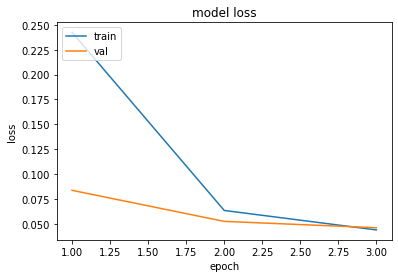

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(test_tags, pred_tags))

           precision    recall  f1-score   support

      per       0.72      0.69      0.71      3545
      gpe       0.95      0.95      0.95      3145
      geo       0.77      0.85      0.81      7620
      tim       0.65      0.84      0.73      4067
      org       0.61      0.52      0.56      4033
      art       0.17      0.06      0.09        63
      eve       0.39      0.27      0.32        52
      nat       0.60      0.16      0.26        37

micro avg       0.74      0.77      0.75     22562
macro avg       0.74      0.77      0.75     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 75.5%


# BiLSTM-CNN을 이용한 개체명인식

In [333]:
# 단어 임베딩
inputs_word = tf.keras.Input(shape=(None,), dtype="int32", name="inputs_word")
embs_word = tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=64)(inputs_word)

# char 임베딩
inputs_char = tf.keras.Input(shape=(None,), name="char_input")
embs_char = tf.keras.layers.Embedding(input_dim=len(char2idx), output_dim=30, embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5), name="char_tf.keras.layers.Embedding")(inputs_char)
dropout = tf.keras.layers.Dropout(rate=0.5)(embs_char)
# char 임베딩에 대해서는 tf.keras.layers.Conv1D 수행
conv1d = tf.keras.layers.Conv1D(filters=30, kernel_size=3, padding="same", activation="tanh", strides=1)(dropout)
maxpool = tf.keras.layers.MaxPooling1D()(conv1d)
flat = tf.keras.layers.Flatten()(maxpool)
char = tf.keras.layers.Dropout(0.5)(flat)

# char 임베딩을 tf.keras.layers.Conv1D 수행한 뒤에 단어 임베딩과 연결
output = tf.concat([embs_word, char], axis=3)

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=50, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# 출력층
outputs = tf.keras.layers.Dense(units=tag_size, activation="softmax")(output)
model = Model(inputs=[inputs_word, inputs_char], outputs=[outputs])

model.compile(loss="categorical_crossentropy", optimizer="nadam",  metrics=["acc"])

model.summary()

ValueError: Shape must be rank 3 but is rank 2 for '{{node concat_4}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](embedding_14/embedding_lookup/Identity_1, dropout_18/cond/Identity, concat_4/axis)' with input shapes: [?,?,64], [?,?], [].

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size = 128, epochs = 30, validation_split = 0.1, verbose = 1, callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 34530 samples, validate on 3837 samples
Epoch 1/30
 1024/34530 [..............................] - ETA: 2:10 - loss: 1.9118 - acc: 0.5808

KeyboardInterrupt: ignored